data

In [204]:
import numpy as np

In [205]:
data = np.load("/home/khs/data/hoso_data/2D_dataset_normal.npz")

X = data["X"]
Y = data["Y"]

print(X.shape, Y.shape)

(204, 12, 3, 3) (204, 3)


data split

In [206]:
from sklearn.model_selection import train_test_split

In [207]:
# train/validation/test 버전 - 그냥 나누기
# train / temp
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.30, random_state=42)

# temp → val / test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))

Train: 142
Val: 31
Test: 31


model

In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [209]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [210]:
class CNN2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

learning

In [211]:
epochs = 3000

model = CNN2D()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 200          # 100 epoch 동안 개선 없으면 중단
counter = 0

for epoch in range(epochs):

    # ---- Train ----
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    val_losses.append(val_loss.item())

    # ---- Early Stopping 체크 ----
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1

    if counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break

    if epoch % 20 == 0:
        print(f"Epoch {epoch}")
        print("Train Loss:", loss.item())
        print("Val Loss:", val_loss.item())

print("Best Validation Loss:", best_val_loss)


Epoch 0
Train Loss: 1.1407908201217651
Val Loss: 0.46612676978111267
Epoch 20
Train Loss: 1.0748238563537598
Val Loss: 0.41952380537986755
Epoch 40
Train Loss: 1.048163652420044
Val Loss: 0.4159995913505554
Epoch 60
Train Loss: 0.96296626329422
Val Loss: 0.4322928190231323
Epoch 80
Train Loss: 0.921859622001648
Val Loss: 0.4451647996902466
Epoch 100
Train Loss: 0.8847909569740295
Val Loss: 0.46514829993247986
Epoch 120
Train Loss: 0.8292853832244873
Val Loss: 0.48317524790763855
Epoch 140
Train Loss: 0.8106862902641296
Val Loss: 0.506571352481842
Epoch 160
Train Loss: 0.7215312719345093
Val Loss: 0.4813362956047058
Epoch 180
Train Loss: 0.7573061585426331
Val Loss: 0.47168296575546265
Epoch 200
Train Loss: 0.7667662501335144
Val Loss: 0.466744989156723
Epoch 220
Train Loss: 0.7194480299949646
Val Loss: 0.4716584086418152
Epoch 240
Train Loss: 0.7269429564476013
Val Loss: 0.4699997007846832

Early stopping triggered at epoch 245
Best Validation Loss: 0.4136677384376526


In [212]:
model.load_state_dict(torch.load("best_model.pt"))

/tmp/ipykernel_4147113/1459691621.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

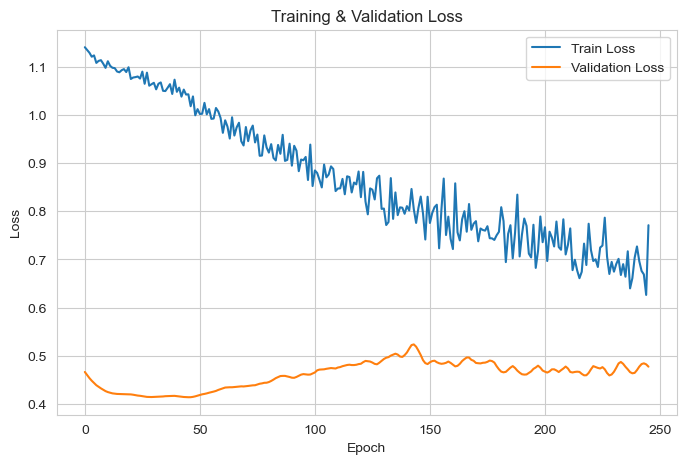

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [214]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, Y_test)

print("Test MSE:", test_loss.item())

Test MSE: 1.0976805686950684


In [215]:
from sklearn.metrics import r2_score

with torch.no_grad():
    preds = model(X_test).cpu().numpy()

true = Y_test.cpu().numpy()

r2 = r2_score(true, preds)
print("R2:", r2)

R2: -0.020288387313485146
